# Instructions from blackboard:

Browse to https://www.kaggle.com/c/morebikes2020/overview for the coursework assignment. You may work alone or in a pair, as you prefer.

A report on your approach and results is due on Wednesday 13th of January 2021 (common deadline for all CDT-only coursework). A BB submission link will follow. 


# Task description on Kaggle: https://www.kaggle.com/c/morebikes2020/

The goal in this assignment is to predict the number of available bicycles in all rental stations 3 hours in advance. There are at least two use cases for such predictions. First, a user plans to rent (or return) a bike in 3 hours' time and wants to choose a bike station which is not empty (or full). Second, the company wants to avoid situations where a station is empty or full and therefore needs to move bikes between stations. For this purpose, they need to know which stations are more likely to be empty or full soon.


The assignment will be organised by 3 phases. During each phase you will be given a particular task. You can earn different proportions of the marks by finishing these phases step by step.
## Phase 1:

In this phase, you will be given the data of 75 stations (Station 201 to Station 275) for the period of one month. The task is to predict availability for each station for the next 3 months.

There are two approaches for this task:

* Train a separate model for each station.
* Train a single model on all stations together.

Implement your models based on both approaches and check which approach is better. Investigate and discuss the results.

(The training data is given by Train.zip, the test data is given by test.csv).

(Build your models and submit the predictions according to the format given by example_leaderboard_submission.csv).
## Phase 2:

Now you will be given a set of linear models trained on other stations (Station 1 to Station 200) with the training data from a whole year. Although these models are not trained on the stations to be predicted, they can still be used since there should be some similarity among different stations. To successfully use these models can help reuse the knowledge learned from a whole year's data.


The task then is to figure out how to predict the stations in Phase 1 by only using these trained models. Investigate the resulting performances and compare to your own classifiers in Phase 1.

(The pre-trained linear models are given by Models.zip).
## Phase 3:

Try to achieve an even better performance by designing a approach to combine your own models with the given linear models.

# Evaluation

The predictions are evaluated according to the mean absolute error (MAE) between the predicted and true values. The winner is the participant who submitted the predictions with the lowest mean absolute error.

# Data

## File descriptions

    Train.zip - the training set, unzip this and you will get the csv file for each station.
    test.csv - the test set.
    sampleSubmission.csv - a sample submission file in the correct format
    Models.zip - linear models pre-trained from other stations.

## Data fields

The data contain 4 station features, 8 time features, 7 weather features, 1 task-specific feature and 4 profile features plus 1 target variable. The target variable is 'bikes' and it is a non-negative integer representing the median number of available bikes during the respective hour in the respective rental station. There are 4 features regarding the station:

    station - integer from 1 to 275, representing the number of the station, also in the file name
    latitude - real number representing geographical latitude of the station
    longitude - real number representing geographical longitude of the station
    numDocks - positive integer representing the maximal number of bikes that can be present in the station


There are 8 features regarding the timepoint:

    timestamp - integer representing the Unix timestamp (seconds since Unix Epoch)
    year - integer with 4 digits
    month - integer from 1 (January) to 12 (December)
    day - integer from 1 to 31
    hour - integer from 0 to 23
    weekday - string (Monday, Tuesday, ..., Sunday)
    weekhour - integer from 1 to 168 representing the hour of the week (Monday 0h is weekhour 1, Sunday 23h is weekhour 168)
    isHoliday - 1 (a national or local holiday), 0 (not a holiday)


There are 7 features regarding weather, these do not differ across stations:

    windMaxSpeed.m.s
    windMeanSpeed.m.s
    windDirection.grades
    temperature.C
    relHumidity.HR
    airPressure.mb
    precipitation.l.m2


There is one feature regarding the number of bikes in the station 3 hours ago:

    bikes_3h_ago

The profile variables are calculated from earlier available timepoints on the same station:

    The 'full_profile_bikes' feature is the arithmetic average of the target variable 'bikes' during all past timepoints with the same weekhour, in the same station.
    The 'full_profile_3h_diff_bikes' feature is the arithmetic average of the calculated feature 'bikes-bikes_3h_ago' during all past timepoints with the same weekhour, in the same station.
    The 'short_*' profile s the same as the full profiles except that it only uses past 4 timepoints with the same weekhour. If there are less than 4 such timepoints then all are used. The missing values are ignored in all profile calculations, i.e. only the timepoints with existing values are averaged.

## MODELS

All models are presented in the CSV format. 

For each station there are 6 linear models, all built using R function rlm from the package MASS, with missing value imputation using function na.roughfix from package randomForest. The models use the following features (plus an intercept term):

    short: bikes_3h_ago, short_profile_3h_diff_bikes, short_profile_bikes
    short_temp: bikes_3h_ago, short_profile_3h_diff_bikes, short_profile_bikes, temperature.C
    full: bikes_3h_ago, full_profile_3h_diff_bikes, full_profile_bikes
    full_temp: bikes_3h_ago, full_profile_3h_diff_bikes, full_profile_bikes, temperature.C
    short_full: bikes_3h_ago, short_profile_3h_diff_bikes, short_profile_bikes, full_profile_3h_diff_bikes, full_profile_bikes
    short_full_temp: bikes_3h_ago, short_profile_3h_diff_bikes, short_profile_bikes, full_profile_3h_diff_bikes, full_profile_bikes, temperature.C


# Training data

In [1]:
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

all_files = all_files = glob.glob(os.path.join('Train/Train', '*.csv'))
df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

In [2]:
df.head()

,station,latitude,longitude,numDocks,timestamp,year,month,day,hour,weekday,weekhour,isHoliday,windMaxSpeed.m.s,windMeanSpeed.m.s,windDirection.grades,temperature.C,relHumidity.HR,airPressure.mb,precipitation.l.m2,bikes_3h_ago,full_profile_3h_diff_bikes,full_profile_bikes,short_profile_3h_diff_bikes,short_profile_bikes,bikes
0,245,39.48143,-0.393436,20,1.412114e+09,2014,10,1,0,Wednesday,49,0,11.3,3.2,67.5,21.3,85.0,855.3,0.0,NaN,NaN,NaN,NaN,NaN,1.0
1,245,39.48143,-0.393436,20,1.412118e+09,2014,10,1,1,Wednesday,50,0,1.6,0.0,157.5,21.1,86.0,1000.6,0.0,NaN,NaN,NaN,NaN,NaN,1.0
2,245,39.48143,-0.393436,20,1.412122e+09,2014,10,1,2,Wednesday,51,0,1.6,0.0,112.5,20.9,86.0,880.6,0.0,NaN,NaN,NaN,NaN,NaN,2.0
3,245,39.48143,-0.393436,20,1.412125e+09,2014,10,1,3,Wednesday,52,0,0.0,0.0,146.3,20.4,88.0,859.8,0.0,1.0,NaN,NaN,NaN,NaN,3.0
4,245,39.48143,-0.393436,20,1.412129e+09,2014,10,1,4,Wednesday,53,0,6.4,3.2,157.5,20.3,87.0,898.1,0.0,1.0,NaN,NaN,NaN,NaN,3.0


In [3]:
df.describe()

,station,latitude,longitude,numDocks,timestamp,year,month,day,hour,weekhour,isHoliday,windMaxSpeed.m.s,windMeanSpeed.m.s,windDirection.grades,temperature.C,relHumidity.HR,airPressure.mb,precipitation.l.m2,bikes_3h_ago,full_profile_3h_diff_bikes,full_profile_bikes,short_profile_3h_diff_bikes,short_profile_bikes,bikes
count,55875.000000,55875.000000,55875.000000,55875.000000,5.587500e+04,55875.0,55875.0,55875.000000,55875.000000,55875.000000,55875.000000,55800.000000,55800.000000,55500.000000,55800.000000,55800.000000,55800.000000,55800.0,55575.000000,43050.000000,43275.000000,43050.000000,43275.000000,55800.000000
mean,238.000000,39.471010,-0.372940,19.560000,1.413454e+09,2014.0,10.0,16.013423,11.487248,84.583893,0.064430,11.406855,4.694489,170.227162,21.707796,65.943548,1002.257258,0.0,7.437607,0.002956,7.412268,0.002956,7.412268,7.442186
std,21.648904,0.013061,0.023094,5.702074,7.742329e+05,0.0,0.0,8.945842,6.926340,46.566917,0.245519,8.664456,4.583093,86.912565,3.271253,16.724256,42.523692,0.0,6.542969,4.686462,5.957532,4.686462,5.957532,6.541292
min,201.000000,39.444093,-0.409316,14.000000,1.412114e+09,2014.0,10.0,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,13.900000,18.000000,811.900000,0.0,0.000000,-39.000000,0.000000,-39.000000,0.000000,0.000000
25%,219.000000,39.462808,-0.393181,15.000000,1.412784e+09,2014.0,10.0,8.000000,5.000000,47.000000,0.000000,4.800000,1.600000,135.000000,19.400000,54.000000,1009.675000,0.0,2.000000,-1.666667,2.750000,-1.666667,2.750000,2.000000
50%,238.000000,39.469844,-0.375973,20.000000,1.413454e+09,2014.0,10.0,16.000000,11.000000,85.000000,0.000000,9.700000,3.200000,180.000000,21.350000,68.000000,1015.350000,0.0,6.000000,0.000000,6.000000,0.000000,6.000000,6.000000
75%,257.000000,39.480591,-0.354640,20.000000,1.414123e+09,2014.0,10.0,24.000000,17.000000,122.000000,0.000000,16.100000,6.400000,202.500000,23.400000,81.000000,1021.500000,0.0,12.000000,1.666667,11.000000,1.666667,11.000000,12.000000
max,275.000000,39.495034,-0.328902,40.000000,1.414793e+09,2014.0,10.0,31.000000,23.000000,168.000000,1.000000,43.500000,27.400000,337.500000,34.600000,91.000000,1084.900000,0.0,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000


In [4]:
df.isnull().sum()

station                            0
latitude                           0
longitude                          0
numDocks                           0
timestamp                          0
year                               0
month                              0
day                                0
hour                               0
weekday                            0
weekhour                           0
isHoliday                          0
windMaxSpeed.m.s                  75
windMeanSpeed.m.s                 75
windDirection.grades             375
temperature.C                     75
relHumidity.HR                    75
airPressure.mb                    75
precipitation.l.m2                75
bikes_3h_ago                     300
full_profile_3h_diff_bikes     12825
full_profile_bikes             12600
short_profile_3h_diff_bikes    12825
short_profile_bikes            12600
bikes                             75
dtype: int64

In [5]:
df[df.timestamp == 1414285200.0].isnull().sum()

station                         0
latitude                        0
longitude                       0
numDocks                        0
timestamp                       0
year                            0
month                           0
day                             0
hour                            0
weekday                         0
weekhour                        0
isHoliday                       0
windMaxSpeed.m.s               75
windMeanSpeed.m.s              75
windDirection.grades           75
temperature.C                  75
relHumidity.HR                 75
airPressure.mb                 75
precipitation.l.m2             75
bikes_3h_ago                    0
full_profile_3h_diff_bikes      0
full_profile_bikes              0
short_profile_3h_diff_bikes     0
short_profile_bikes             0
bikes                          75
dtype: int64

In [6]:
df[df.timestamp == 1414285200.0+3600*3].isnull().sum()

station                         0
latitude                        0
longitude                       0
numDocks                        0
timestamp                       0
year                            0
month                           0
day                             0
hour                            0
weekday                         0
weekhour                        0
isHoliday                       0
windMaxSpeed.m.s                0
windMeanSpeed.m.s               0
windDirection.grades            0
temperature.C                   0
relHumidity.HR                  0
airPressure.mb                  0
precipitation.l.m2              0
bikes_3h_ago                   75
full_profile_3h_diff_bikes      0
full_profile_bikes              0
short_profile_3h_diff_bikes     0
short_profile_bikes             0
bikes                           0
dtype: int64

In [7]:
df[(df.timestamp != 1414285200.0) & (df.timestamp != 1414285200.0+3600*3)].isnull().sum()

station                            0
latitude                           0
longitude                          0
numDocks                           0
timestamp                          0
year                               0
month                              0
day                                0
hour                               0
weekday                            0
weekhour                           0
isHoliday                          0
windMaxSpeed.m.s                   0
windMeanSpeed.m.s                  0
windDirection.grades             300
temperature.C                      0
relHumidity.HR                     0
airPressure.mb                     0
precipitation.l.m2                 0
bikes_3h_ago                     225
full_profile_3h_diff_bikes     12825
full_profile_bikes             12600
short_profile_3h_diff_bikes    12825
short_profile_bikes            12600
bikes                              0
dtype: int64

In [8]:
df[(df.timestamp != 1414285200.0) & (df.timestamp != 1414285200.0+3600*3) & (df.timestamp >= (df.timestamp.min() + (60*60*(24*7+3))))].isnull().sum()

station                          0
latitude                         0
longitude                        0
numDocks                         0
timestamp                        0
year                             0
month                            0
day                              0
hour                             0
weekday                          0
weekhour                         0
isHoliday                        0
windMaxSpeed.m.s                 0
windMeanSpeed.m.s                0
windDirection.grades           300
temperature.C                    0
relHumidity.HR                   0
airPressure.mb                   0
precipitation.l.m2               0
bikes_3h_ago                     0
full_profile_3h_diff_bikes       0
full_profile_bikes               0
short_profile_3h_diff_bikes      0
short_profile_bikes              0
bikes                            0
dtype: int64

In [9]:
df[(df.timestamp != 1414285200.0) & (df.timestamp >= (df.timestamp.min() + 60*60*24*7))]

,station,latitude,longitude,numDocks,timestamp,year,month,day,hour,weekday,weekhour,isHoliday,windMaxSpeed.m.s,windMeanSpeed.m.s,windDirection.grades,temperature.C,relHumidity.HR,airPressure.mb,precipitation.l.m2,bikes_3h_ago,full_profile_3h_diff_bikes,full_profile_bikes,short_profile_3h_diff_bikes,short_profile_bikes,bikes
168,245,39.481430,-0.393436,20,1.412719e+09,2014,10,8,0,Wednesday,49,0,4.8,1.6,0.0,23.3,59.0,1011.7,0.0,1.0,NaN,1.00,NaN,1.00,0.0
169,245,39.481430,-0.393436,20,1.412723e+09,2014,10,8,1,Wednesday,50,0,3.2,0.0,270.0,22.6,54.0,1011.6,0.0,3.0,NaN,1.00,NaN,1.00,0.0
170,245,39.481430,-0.393436,20,1.412726e+09,2014,10,8,2,Wednesday,51,0,3.2,0.0,225.0,22.0,57.0,1011.7,0.0,1.0,NaN,2.00,NaN,2.00,0.0
171,245,39.481430,-0.393436,20,1.412730e+09,2014,10,8,3,Wednesday,52,0,1.6,0.0,180.0,21.5,59.0,1011.5,0.0,0.0,2.00,3.00,2.00,3.00,0.0
172,245,39.481430,-0.393436,20,1.412734e+09,2014,10,8,4,Wednesday,53,0,3.2,1.6,202.5,20.8,62.0,1011.1,0.0,0.0,2.00,3.00,2.00,3.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55870,220,39.458389,-0.344496,15,1.414778e+09,2014,10,31,19,Friday,116,0,9.7,4.8,22.5,20.2,80.0,1023.5,0.0,15.0,0.25,8.75,0.25,8.75,14.0
55871,220,39.458389,-0.344496,15,1.414782e+09,2014,10,31,20,Friday,117,0,6.4,1.6,337.5,20.2,82.0,1023.9,0.0,15.0,-2.50,8.75,-2.50,8.75,12.0
55872,220,39.458389,-0.344496,15,1.414786e+09,2014,10,31,21,Friday,118,0,3.2,0.0,315.0,20.0,83.0,1024.0,0.0,15.0,-4.25,8.00,-4.25,8.00,11.0
55873,220,39.458389,-0.344496,15,1.414789e+09,2014,10,31,22,Friday,119,0,0.0,0.0,146.3,19.3,84.0,1024.4,0.0,14.0,0.50,9.25,0.50,9.25,8.0


In [10]:
(df[(df['windMeanSpeed.m.s'] == 0)].isnull()).sum()

station                           0
latitude                          0
longitude                         0
numDocks                          0
timestamp                         0
year                              0
month                             0
day                               0
hour                              0
weekday                           0
weekhour                          0
isHoliday                         0
windMaxSpeed.m.s                  0
windMeanSpeed.m.s                 0
windDirection.grades            300
temperature.C                     0
relHumidity.HR                    0
airPressure.mb                    0
precipitation.l.m2                0
bikes_3h_ago                    150
full_profile_3h_diff_bikes     2475
full_profile_bikes             2325
short_profile_3h_diff_bikes    2475
short_profile_bikes            2325
bikes                             0
dtype: int64

(-0.40931619469999997, -0.3289019589, 39.4440930091, 39.4950341762)


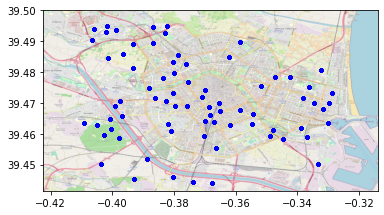

In [11]:
fig, ax = plt.subplots()

IdealBBox = (df.longitude.min(),   df.longitude.max(),      
         df.latitude.min(), df.latitude.max())

print(IdealBBox)

ActualMapBBox = (-0.4225, -0.3139, 39.4415, 39.5001)

val_map = plt.imread('map.png')

ax.scatter(df.longitude, df.latitude, zorder=1, alpha= 0.2, c='b', s=10)
ax.set_xlim(ActualMapBBox[0],ActualMapBBox[1])
ax.set_ylim(ActualMapBBox[2],ActualMapBBox[3])
ax.imshow(val_map, zorder=0, extent = ActualMapBBox, aspect= 'equal')

Bikes stations are located around the Spanish city of Valancia

<AxesSubplot:title={'center':'total bikes docked'}, xlabel='datetime'>

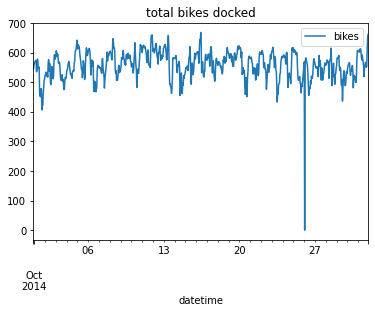

In [12]:
total_docked_bikes = df.groupby('timestamp')['bikes'].sum().reset_index()
total_docked_bikes['datetime'] = total_docked_bikes['timestamp'].values.astype(dtype='datetime64[s]')
total_docked_bikes.plot('datetime', 'bikes', title="total bikes docked")

So doesn't seem unreasonable to assume bikes are not being added or removed from the system (total number docked varies between about 450 and 650 and difference doesn't seem unreasonable number to be in use at busy times).

It does show the oddity on 2am 26th October (due to the change from summer time corresponding to timestamps 1414285200 and 1414281600 so actually there are two 2ams that day in local time).

## Missing values
Weather and bikes count features missing at timestamp 1414285200 (probably related to clocks changing - there are two 2ams on Sunday 26th October corresponding to timestamps 1414285200 and 1414281600. This has a knock on effect on bikes_3h_ago in 3 hours time. Profile features are probably working with one less data point than might expected in following timestamps.

bikes_3h_ago is missing for all stations for the first 3 timestamps (as might be expected if engineered from the data).

Profile data is missing at the earliest timestamps while enough data is collected (so in the first week until weekhour rolls back round again to 1: 24\*7\*75 = 12,600 entries, with an extra 3 hour delay for the profile features relying on bikes_3h_ago).

Wind direction which is missing from a further 4 timestamps for each station (300 examples). This is due to a 0 wind speed (max and mean).



In [13]:
df.corr()

,station,latitude,longitude,numDocks,timestamp,year,month,day,hour,weekhour,isHoliday,windMaxSpeed.m.s,windMeanSpeed.m.s,windDirection.grades,temperature.C,relHumidity.HR,airPressure.mb,precipitation.l.m2,bikes_3h_ago,full_profile_3h_diff_bikes,full_profile_bikes,short_profile_3h_diff_bikes,short_profile_bikes,bikes
station,1.000000e+00,1.027841e-01,-3.782233e-01,-2.165669e-01,0.000000e+00,NaN,NaN,-2.616029e-18,2.035410e-20,-7.750295e-19,-3.887884e-19,-1.822087e-18,-1.374544e-18,6.967653e-20,2.499358e-19,5.177127e-19,-1.022489e-18,NaN,0.023757,-0.001951,0.027371,-0.001951,0.027371,0.023292
latitude,1.027841e-01,1.000000e+00,-2.035786e-01,-1.644551e-01,4.616638e-18,NaN,NaN,1.074375e-15,-2.095429e-17,-9.503742e-18,-2.194056e-17,-5.082103e-17,4.313850e-17,3.618672e-17,-1.937564e-17,-3.218167e-17,-6.423342e-18,NaN,-0.194511,0.000395,-0.257919,0.000395,-0.257919,-0.194553
longitude,-3.782233e-01,-2.035786e-01,1.000000e+00,9.669194e-02,7.719926e-19,NaN,NaN,-3.284590e-16,2.250264e-17,-1.292621e-17,-8.598935e-17,5.412020e-17,-3.066744e-17,3.026316e-18,-3.105475e-17,-3.548368e-17,-7.002048e-18,NaN,0.283092,0.000566,0.323892,0.000566,0.323892,0.283121
numDocks,-2.165669e-01,-1.644551e-01,9.669194e-02,1.000000e+00,-2.027497e-17,NaN,NaN,7.587766e-17,3.063745e-17,1.121074e-17,7.828393e-16,3.202219e-17,8.644343e-17,-1.644014e-16,2.787209e-17,4.542746e-18,5.288778e-17,NaN,0.120884,0.001138,0.119199,0.001138,0.119199,0.120288
timestamp,0.000000e+00,4.616638e-18,7.719926e-19,-2.027497e-17,1.000000e+00,NaN,NaN,9.994796e-01,3.017552e-02,-4.163978e-02,-1.616795e-01,-1.806807e-01,-1.652543e-01,-4.436672e-02,-2.164172e-01,-6.935521e-02,5.471470e-01,NaN,-0.003598,-0.000031,0.013253,-0.000031,0.013253,-0.002361
year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
day,-2.616029e-18,1.074375e-15,-3.284590e-16,7.587766e-17,9.994796e-01,NaN,NaN,1.000000e+00,-2.055260e-03,-4.624452e-02,-1.617365e-01,-1.895454e-01,-1.734895e-01,-4.210258e-02,-2.310450e-01,-6.432674e-02,5.466684e-01,NaN,-0.002441,-0.000208,0.014661,-0.000208,0.014661,-0.001383
hour,2.035410e-20,-2.095429e-17,2.250264e-17,3.063745e-17,3.017552e-02,NaN,NaN,-2.055260e-03,1.000000e+00,1.458967e-01,4.831385e-04,2.764694e-01,2.564885e-01,-6.009020e-02,4.575550e-01,-1.793665e-01,3.271924e-02,NaN,-0.035255,0.004371,-0.033158,0.004371,-0.033158,-0.029838
weekhour,-7.750295e-19,-9.503742e-18,-1.292621e-17,1.121074e-17,-4.163978e-02,NaN,NaN,-4.624452e-02,1.458967e-01,1.000000e+00,2.024044e-01,-5.068208e-02,-4.397097e-02,-1.133151e-01,7.472704e-02,6.623860e-02,-1.238775e-01,NaN,0.008527,0.007048,0.018749,0.007048,0.018749,0.013216


In [14]:
df.cov()

,station,latitude,longitude,numDocks,timestamp,year,month,day,hour,weekhour,isHoliday,windMaxSpeed.m.s,windMeanSpeed.m.s,windDirection.grades,temperature.C,relHumidity.HR,airPressure.mb,precipitation.l.m2,bikes_3h_ago,full_profile_3h_diff_bikes,full_profile_bikes,short_profile_3h_diff_bikes,short_profile_bikes,bikes
station,4.686751e+02,2.906255e-02,-1.890974e-01,-2.673381e+01,0.000000e+00,0.0,0.0,-5.066403e-16,3.052050e-18,-7.813249e-16,-2.066492e-18,-3.417797e-16,-1.363808e-16,1.311007e-16,1.770022e-17,1.874440e-16,-9.412950e-16,0.0,3.365153,-0.197953,3.530216,-0.197953,3.530216,3.298482
latitude,2.906255e-02,1.705863e-04,-6.140529e-05,-1.224763e-02,4.668416e-14,0.0,0.0,1.255305e-16,-1.895609e-18,-5.780218e-18,-7.035652e-20,-5.751178e-18,2.582235e-18,4.107749e-17,-8.278323e-19,-7.029549e-18,-3.567501e-18,0.0,-0.016622,0.000024,-0.020069,0.000024,-0.020069,-0.016622
longitude,-1.890974e-01,-6.140529e-05,5.333386e-04,1.273282e-02,1.380341e-14,0.0,0.0,-6.785844e-17,3.599472e-18,-1.390114e-17,-4.875630e-19,1.082935e-17,-3.245919e-18,6.074330e-18,-2.346085e-18,-1.370493e-17,-6.876343e-18,0.0,0.042776,0.000061,0.044562,0.000061,0.044562,0.042770
numDocks,-2.673381e+01,-1.224763e-02,1.273282e-02,3.251365e+01,-8.950858e-11,0.0,0.0,3.870508e-15,1.210011e-15,2.976766e-15,1.095948e-15,1.582068e-15,2.259038e-15,-8.147435e-14,5.198961e-16,4.332096e-16,1.282387e-14,0.0,4.509983,0.030397,4.049243,0.030397,4.049243,4.486596
timestamp,0.000000e+00,4.668416e-14,1.380341e-14,-8.950858e-11,5.994366e+11,0.0,0.0,6.922561e+06,1.618193e+05,-1.501266e+06,-3.073344e+04,-1.211935e+06,-5.863241e+05,-2.989737e+06,-5.480653e+05,-8.979502e+05,1.801198e+07,0.0,-18151.661402,-87.866153,47344.442390,-87.866153,47344.442390,-11953.705899
year,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
month,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
day,-5.066403e-16,1.255305e-16,-6.785844e-17,3.870508e-15,6.922561e+06,0.0,0.0,8.002810e+01,-1.273479e-01,-1.926456e+01,-3.552336e-01,-1.468938e+01,-7.111821e+00,-3.278325e+01,-6.760202e+00,-9.622484e+00,2.079236e+02,0.0,-0.142349,-0.006728,0.604541,-0.006728,0.604541,-0.080898
hour,3.052050e-18,-1.895609e-18,3.599472e-18,1.210011e-15,1.618193e+05,0.0,0.0,-1.273479e-01,4.797419e+01,4.705728e+01,8.215993e-04,1.658195e+01,8.137175e+00,-3.607573e+01,1.036107e+01,-2.076516e+01,9.631221e+00,0.0,-1.593576,0.141420,-1.368479,0.141420,-1.368479,-1.351064
weekhour,-7.813249e-16,-5.780218e-18,-1.390114e-17,2.976766e-15,-1.501266e+06,0.0,0.0,-1.926456e+01,4.705728e+01,2.168478e+03,2.314099e+00,-2.043807e+01,-9.379268e+00,-4.593104e+02,1.137722e+01,5.155872e+01,-2.451701e+02,0.0,2.598689,1.520734,5.136946,1.520734,5.136946,4.023656


In [15]:
df[["weekhour", "windMaxSpeed.m.s", "windMeanSpeed.m.s", "temperature.C", "relHumidity.HR", "airPressure.mb", "bikes_3h_ago", "bikes"]].cov()

,weekhour,windMaxSpeed.m.s,windMeanSpeed.m.s,temperature.C,relHumidity.HR,airPressure.mb,bikes_3h_ago,bikes
weekhour,2168.477745,-20.438068,-9.379268,11.377220,51.558720,-245.170120,2.598689,4.023656
windMaxSpeed.m.s,-20.438068,75.072790,38.227121,14.458539,-66.955517,-4.717480,0.041451,-0.615546
windMeanSpeed.m.s,-9.379268,38.227121,21.004741,6.750796,-30.834869,-5.689746,-0.005751,-0.298069
temperature.C,11.377220,14.458539,6.750796,10.701099,-33.697207,-4.909499,-0.292259,-0.542645
relHumidity.HR,51.558720,-66.955517,-30.834869,-33.697207,279.700751,-158.904589,-0.263361,1.245594
airPressure.mb,-245.170120,-4.717480,-5.689746,-4.909499,-158.904589,1808.264397,0.413486,0.622752
bikes_3h_ago,2.598689,0.041451,-0.005751,-0.292259,-0.263361,0.413486,42.810440,28.815939
bikes,4.023656,-0.615546,-0.298069,-0.542645,1.245594,0.622752,28.815939,42.788500


In [16]:
df[["weekhour", "windMaxSpeed.m.s", "windMeanSpeed.m.s", "temperature.C", "relHumidity.HR", "airPressure.mb", "bikes_3h_ago", "bikes"]].corr()

,weekhour,windMaxSpeed.m.s,windMeanSpeed.m.s,temperature.C,relHumidity.HR,airPressure.mb,bikes_3h_ago,bikes
weekhour,1.000000,-0.050682,-0.043971,0.074727,0.066239,-0.123877,0.008527,0.013216
windMaxSpeed.m.s,-0.050682,1.000000,0.962657,0.510116,-0.462060,-0.012804,0.000730,-0.010861
windMeanSpeed.m.s,-0.043971,0.962657,1.000000,0.450279,-0.402288,-0.029195,-0.000192,-0.009942
temperature.C,0.074727,0.510116,0.450279,1.000000,-0.615932,-0.035293,-0.013624,-0.025359
relHumidity.HR,0.066239,-0.462060,-0.402288,-0.615932,1.000000,-0.223439,-0.002408,0.011386
airPressure.mb,-0.123877,-0.012804,-0.029195,-0.035293,-0.223439,1.000000,0.001503,0.002239
bikes_3h_ago,0.008527,0.000730,-0.000192,-0.013624,-0.002408,0.001503,1.000000,0.673157
bikes,0.013216,-0.010861,-0.009942,-0.025359,0.011386,0.002239,0.673157,1.000000


# Ideas

Bike usage and location is likely to be heavily influenced by commuters during weekdays (particularly around 9am and 5pm as commuters move bikes from suburbs to central offices) and leisure use on weekends. Therefore I would expect number of bikes in a station to be similar to number of bikes in the station at the same time on the same day of the week in the past.

I would expect bike usage to be influenced by weather: it's not much fun cycling in the wind and rain, cold is less of an issue but maybe when it's very hot or very humid usage might descrease (particularly for commuting times when riders may not wish to get too hot and sweaty on their way to an important meeting at work).

I would expect bike usage to decrease during the winter (indepently of poorer weather) due to dislike of cycling in the dark. 

The training data is from Valencia in Spain. For stations 201-275 we have it for October 2014.

The test data (again from the same stations 201-275) is from November 2014, December 2014 and January 2015 so for first part we do not need to worry about seasonal effects too much (all in winter). However, I would expect a dip in usage around Christmas and New Year.

## Assumptions

* Closed system - bike taken from one station to another and no new bikes added and no bikes removed (expect that they are in use)
* Some intervention by someone to move bikes around other than just users.

## Simple baselines

* No change from previous hour
* No change from 3 hours ago
* Use one of the smoothed estimates which in themselves build in a simple model expecting usage to be dependent on the hour of the week (ie should pick up some of the different weekday and weekend fluctuations)

# Questions

Task talks about predicting 3 hours ahead. Does that mean it's cheating to use any data that's more recent than 3 hours before prediction time? Guess it could be a hypothesis: do accurate weather forecasts improve predictions?

# Test data

In [17]:
test_data = pd.read_csv('test.csv')

In [18]:
test_data.describe()

,Id,station,latitude,longitude,numDocks,timestamp,year,month,day,hour,weekhour,isHoliday,windMaxSpeed.m.s,windMeanSpeed.m.s,windDirection.grades,temperature.C,relHumidity.HR,airPressure.mb,precipitation.l.m2,bikes_3h_ago,full_profile_3h_diff_bikes,full_profile_bikes,short_profile_3h_diff_bikes,short_profile_bikes
count,2250.000000,2250.000000,2250.000000,2250.000000,2250.000000,2.250000e+03,2250.000000,2250.000000,2250.000000,2250.000000,2250.000000,2250.000000,2250.000000,2250.000000,2250.000000,2250.000000,2250.000000,2250.000000,2250.000000,2250.000000,2250.000000,2250.000000,2250.000000,2250.000000
mean,1125.500000,238.000000,39.471010,-0.372940,19.560000,1.418770e+09,2014.334667,7.997333,15.765333,11.767111,84.607111,0.064000,11.377333,4.079911,181.716800,12.926578,64.204889,1010.362089,0.008622,7.759556,0.073909,7.597906,0.009852,7.773815
std,649.663374,21.653523,0.013064,0.023099,5.703291,2.247053e+06,0.471979,4.980531,8.691749,6.943460,48.461592,0.244807,9.221720,4.404740,67.840312,4.084343,17.402368,17.065828,0.092475,6.218881,3.903431,5.044116,3.766784,5.176288
min,1.000000,201.000000,39.444093,-0.409316,14.000000,1.414807e+09,2014.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.100000,17.000000,896.900000,0.000000,0.000000,-30.300000,0.000000,-27.500000,0.000000
25%,563.250000,219.000000,39.462808,-0.393181,15.000000,1.416823e+09,2014.000000,1.000000,8.000000,6.000000,43.250000,0.000000,4.800000,1.600000,157.500000,9.900000,50.000000,1005.700000,0.000000,2.000000,-1.250000,4.000000,-1.250000,3.750000
50%,1125.500000,238.000000,39.469844,-0.375973,20.000000,1.418774e+09,2014.000000,11.000000,16.000000,12.000000,84.000000,0.000000,8.000000,3.200000,180.000000,12.900000,65.000000,1013.550000,0.000000,7.000000,0.087121,6.639610,0.000000,7.000000
75%,1687.750000,257.000000,39.480591,-0.354640,20.000000,1.420697e+09,2015.000000,12.000000,23.000000,18.000000,127.000000,0.000000,14.500000,6.400000,225.000000,15.975000,79.000000,1021.500000,0.000000,12.000000,1.298529,10.142857,1.250000,10.750000
max,2250.000000,275.000000,39.495034,-0.328902,40.000000,1.422738e+09,2015.000000,12.000000,31.000000,23.000000,168.000000,1.000000,62.800000,25.700000,337.500000,25.000000,97.000000,1033.600000,2.600000,37.000000,35.285714,39.571429,34.250000,39.750000


In [19]:
test_data.isnull().sum()

Id                             0
station                        0
latitude                       0
longitude                      0
numDocks                       0
timestamp                      0
year                           0
month                          0
day                            0
hour                           0
weekday                        0
weekhour                       0
isHoliday                      0
windMaxSpeed.m.s               0
windMeanSpeed.m.s              0
windDirection.grades           0
temperature.C                  0
relHumidity.HR                 0
airPressure.mb                 0
precipitation.l.m2             0
bikes_3h_ago                   0
full_profile_3h_diff_bikes     0
full_profile_bikes             0
short_profile_3h_diff_bikes    0
short_profile_bikes            0
dtype: int64

## Missing values in test data

No issues, all values present.

* Max and Mean wind speeds are highly positively correlated (no great surprise there).
* Relative Humidity and Temperature are somewhat negatively correlated (again as one would expect).
* Some correlation between bikes_3h_ago and bikes and unsurprisingly no great linear correlation with other variables (after all on cold, windy days just means more bikes stay in one station rather than move between stations). Perhaps need to look at correlations at each station (or clusters of stations). Also raw bikes count is likely to be confused by size of the station (20 bikes at a station with 200 docks is in quite a different state to one with only 20 docks).